<a href="https://colab.research.google.com/github/sganguly3000ai/makemore/blob/main/makemore_03_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bigram character level language model using neural network MLP**

In [2]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
%matplotlib inline


In [3]:
# the yob1996.txt file is locally stored in the downloads/names directory
# and should be uploaded to the sample_data directory in colab before running
# create a list of words or names

# create a list of words or names

names   = np.loadtxt('sample_data/yob1996.txt', delimiter=',', usecols = 0, dtype = str)
lnames  = np.char.lower(names)
words  = pd.unique(lnames)



In [4]:
print(f'{names[:8]} :Shape = {names.shape}\n{lnames[:8]} :Shape = {lnames.shape}\n{words[:8]} :Shape = {words.shape}')


['Emily' 'Jessica' 'Ashley' 'Sarah' 'Samantha' 'Taylor' 'Hannah' 'Alexis'] :Shape = (26426,)
['emily' 'jessica' 'ashley' 'sarah' 'samantha' 'taylor' 'hannah' 'alexis'] :Shape = (26426,)
['emily' 'jessica' 'ashley' 'sarah' 'samantha' 'taylor' 'hannah' 'alexis'] :Shape = (24306,)


In [5]:
# create a dictionary of the lowercase english alphabets + '.' as the start and end character for a word

chars = list(string.ascii_lowercase)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
  X, Y = [],[]


  for w in words:
    context = [0] * block_size

    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X, Y

np.random.seed(42)
np.random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# train,dev and test datasets (80,10,10)
Xtr, Ytr        =  build_dataset(words[:n1])
Xdev, Ydev      =  build_dataset(words[n1:n2])
Xtest, Ytest    =  build_dataset(words[n2:])


torch.Size([142863, 3]) torch.Size([142863])
torch.Size([17771, 3]) torch.Size([17771])
torch.Size([17942, 3]) torch.Size([17942])


In [7]:
# MLP revisited
n_emb       = 10 # the dimensionality of the character embedding vectors
n_hidden    = 200 # the number of neurons in the hidden layer of the MLP

# define the parameters
g   =   torch.Generator().manual_seed(2147483647)         # for reproducibility
C   =   torch.randn((vocab_size,n_emb),             generator = g)
W1  =   torch.randn((n_emb*block_size, n_hidden),   generator = g)
b1  =   torch.randn((n_hidden),                     generator = g)
W2  =   torch.randn((n_hidden,vocab_size),          generator = g)      # 27 possible outputs for 27 lowercase english characters
b2  =   torch.randn((vocab_size),                   generator = g)

parameters  = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))                              # number of parameters in total

for p in parameters:
  p.requires_grad = True

11897


In [ ]:
# to figure out what learning rate to use
# guess a learning rate (one low and one high)
# plug in the (guessed) low learning rate and train the model - observe the rate at which the loss is going down
# plug in the (guessed) high learning rate and train the model - observe the rate at which the loss is going down
# the (guessed) low and high lr should both not make the loss go down fairly quickly
# for this particular model it seems like the low and high should be .001 and 1

lre = torch.linspace(-3,0,1000)   # create evenly spaced values between -3 and 0
lrs = 10**lre                     # taking the exponent gives us a tensor of values in the range 1 and .001

# now instead of using the guessed learning rate (lr), we will run the model with each learning rate in lrs
# and track the losses for a 1000 iterations of training the model

In [10]:
# optimization using Xtr

max_steps       = 200000
batch_size      = 32
lossi           = []


# lri   = []    # used to track the learning rate
# lossi = []    # used to track the losses for the given lr

for i in range(max_steps):

  # minibatch construct (pluck bath_size samples out of the total number of samples randomly
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]


  # forward pass
  emb       = C[Xb]                       # embed the characters into vectors
  embcat    = emb.view(emb.shape[0], -1)  # concatenate the vectors
  hpreact   = embcat @ W1 + b1            # hidden layer pre-activation
  h         = torch.tanh(hpreact)         # hidden layer
  logits  = h @ W2 + b2                   # output layer
  # counts  = logits.exp()
  # probs   = counts / counts.sum(1, keepdims = True)
  # loss    = -probs[torch.arange(num_of_labels),Y].log().mean()
  loss = F.cross_entropy(logits, Yb)      # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # gradient update
  lr = 0.1 if i < 100000 else .01         # step learning rate decay
  for p in parameters:
    #lr        = lrs[i]
    p.data   += -lr * p.grad

  # track stats for lr
  if i % 10000 == 0:                      # print every 10000 iterations
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.item())


      0/ 200000: 2.087491
  10000/ 200000: 2.191956
  20000/ 200000: 1.852420
  30000/ 200000: 1.832281
  40000/ 200000: 1.680371
  50000/ 200000: 1.907246
  60000/ 200000: 1.936236
  70000/ 200000: 2.308415
  80000/ 200000: 2.241536
  90000/ 200000: 2.019626
 100000/ 200000: 2.247876
 110000/ 200000: 2.202846
 120000/ 200000: 1.842506
 130000/ 200000: 1.676755
 140000/ 200000: 1.911015
 150000/ 200000: 1.577655
 160000/ 200000: 1.840847
 170000/ 200000: 1.837021
 180000/ 200000: 2.172861
 190000/ 200000: 1.904201


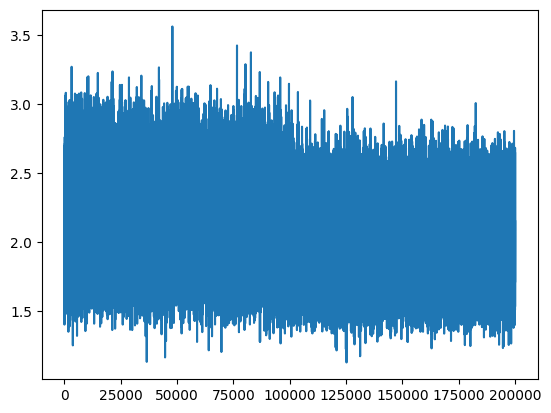

In [11]:
plt.plot(lossi)

In [13]:
# run to evaluate what the train and validation data is showing as per as the loss

@torch.no_grad()                                # this decorator disables gradient tracking
def split_loss(split):
  x,y = {'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
        }[split]

  emb       = C[x]                       # embed the characters into vectors
  embcat    = emb.view(emb.shape[0], -1)  # concatenate the vectors
  hpreact   = embcat @ W1 + b1            # hidden layer pre-activation
  h         = torch.tanh(hpreact)         # hidden layer
  logits  = h @ W2 + b2
  loss = F.cross_entropy(logits, y)       # loss function
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9882811307907104
val 2.073927879333496


2.5666401386260986


2.5784599781036377


In [14]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0]*block_size # initialize with all '...'
  while True:

    emb     = C[torch.tensor([context])]                                          #(1,block_size,d)
    h       = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits  = h @ W2 + b2
    probs   = F.softmax(logits, dim=1)

    # sample from the distribution
    ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]

    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

montaymyannieen.
nichalla.
emman.
jadrie.
cadejanielin.
shy.
jenne.
elissa.
nar.
katelvintel.
nyshaber.
daimies.
kindreell.
panterian.
brence.
rayshun.
ehs.
kayjahs.
kyla.
hil.
